In [ ]:
import xgboost as xgb
import numpy as np
from scipy import sparse
from utils import *

In [ ]:
def load_metadata(path):
  # A helper function to load the csv file.
  if not os.path.exists(path):
    raise Exception("The specified path {} does not exist.".format(path))
    # Initialize the data.
  data = {}
  # Iterate over the row to fill in the data.
  with open(path, "r") as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      try:
        data[int(row[0])] = {}
        if int(row[1]) == 0:
          data[int(row[0])]["gender"] = np.nan
        else:
          data[int(row[0])]["gender"] = int(row[1])
        if row[2] == "":
          data[int(row[0])]["date_of_birth"] = np.nan
        else:
          row_split = row[2].split(" ")[0][:4]
          age = 2020 - int(row_split)
          if age > 2:
            data[int(row[0])]["date_of_birth"] = age
          else:
            data[int(row[0])]["date_of_birth"] = np.nan
        if row[3] == "":
          data[int(row[0])]["premium_pupil"] = np.nan
        else:
          data[int(row[0])]["premium_pupil"] = int(float(row[3]))
      except ValueError:
        # Pass first row.
        pass
      except IndexError:
        # is_correct might not be available.
        pass
  return data

In [ ]:
def load_q_metadata(path):
  # A helper function to load the csv file.
  if not os.path.exists(path):
    raise Exception("The specified path {} does not exist.".format(path))
    # Initialize the data.
  data = {}
  # Iterate over the row to fill in the data.
  with open(path, "r") as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      try:
        data[int(row[0])] = {}
        subjects = row[1][1:-2].split(",")
        subjects = [int(c.strip()) for c in subjects]
        data[int(row[0])]["subjects"] = subjects
      except ValueError:
        # Pass first row.
        pass
      except IndexError:
        # is_correct might not be available.
        pass
  return data

In [ ]:
def sigmoid(x):
    """ Apply sigmoid function.
    """
    return np.exp(x) / (1 + np.exp(x))

In [ ]:
def createNpMatrix(data, metadata, user_acc, q_acc, user_num_q, q_num_user,q_age, q_metadata, subject_acc, subject_num, model_i, tolabel):
  d = []
  label = []
  theta = np.load("../models/irt_500_theta.npy")
  beta = np.load("../models/irt_500_beta.npy")

  for i in range(len(data["user_id"])):
    u = data["user_id"][i]
    q = data["question_id"][i]
    
    if user_acc[u] > -1:
      row = []
      row.append(user_acc[u])
      row.append(q_acc[q])
      #avg_acc = 0.75*subject_acc[q_metadata[q]["subjects"][-2]] + 0.25*subject_acc[q_metadata[q]["subjects"][-2]]
      #for subject in q_metadata[q]["subjects"]:
      #  avg_acc += subject_acc[subject]
      #avg_acc /= len(q_metadata[q]["subjects"])
      #row.append(subject_acc[q_metadata[q]["subjects"][-1]])
      row.append(subject_acc[q_metadata[q]["subjects"][-2]])
      
      #row.append(subject_acc[q_metadata[q]["subjects"][-1]]) #+ subject_acc[q_metadata[q]["subjects"][-1]])
      #row.append(user_acc[u] + q_acc[q])
      #row.append(user_acc[u] - q_acc[q])
      #row.append(user_acc[u] * q_acc[q])
      #row.append(user_num_q[u])
      #row.append(q_num_user[q])
      #row.append(user_num_q[u]+q_num_user[q])
      #row.append(subject_num[q_metadata[q]["subjects"][-2]])
      #row.append(user_acc[u] + metadata[u]["date_of_birth"])
      row.append(q_age[q])
      row.append(metadata[u]["gender"])
      row.append(metadata[u]["date_of_birth"])
      row.append(metadata[u]["premium_pupil"])
      row.append(theta[u][0])
      row.append(beta[q][0])
      d.append(row)
      if tolabel:
        label.append(data["is_correct"][i])

  d = np.array(d)
  if tolabel:
    label = np.array(label)
  else:
    label = None
  return d, label

In [ ]:
for model_i in range(1,2):
  user_acc = np.full((542),0)
  user_num_q = np.full((542),0)
  q_acc = np.full((1774),0)
  q_num_user = np.full((1774),0)
  q_age = np.full((1774),0)
  q_age_num = np.full((1774),0)
  user_q_age = np.full((542),0)
  subject_acc = np.full((388), 0)
  subject_num = np.full((388), 0)
  s_metadata = load_metadata("../data/student_meta.csv")
  q_metadata = load_q_metadata("../data/question_meta.csv")
  
  #train_array = np.load("../data/cvtrain" + str(model_i) + ".npy")
  #test_array = np.load("../data/cvtest" + str(model_i) + ".npy")

  #train_data = {"user_id": [], "question_id": [], "is_correct": []}
  #val_data = {"user_id": [], "question_id": [], "is_correct": []}
  train_data = load_train_csv("../data")
  val_data = load_valid_csv("../data")
  test_data = load_public_test_csv("../data")
  
  for i in range(len(train_data["user_id"])):
      u = train_data["user_id"][i]
      q = train_data["question_id"][i]
      c = train_data["is_correct"][i]
      
      user_acc[u] += c
      user_num_q[u] += 1
      q_acc[q] += c
      q_num_user[q]  += 1
      for subject in q_metadata[q]["subjects"]:
        subject_acc[subject] += c
        subject_num[subject] += 1 
      if not np.isnan(s_metadata[u]["date_of_birth"]):
        q_age[q] += s_metadata[u]["date_of_birth"]
        q_age_num[q] += 1

  user_acc = user_acc / user_num_q
  q_acc = q_acc / q_num_user
  q_age = q_age / q_age_num
  subject_acc = subject_acc / subject_num
  subject_acc[np.isnan(subject_acc)] = 0
  #print(subject_acc)
  #print(subject_num)
  #val2_data = load_valid_csv("../data")
  nptrain, nptrainlabel = createNpMatrix(train_data, s_metadata,user_acc, q_acc, user_num_q, q_num_user,q_age, q_metadata, subject_acc, subject_num, model_i, True)
  npvalid, npvalidlabel = createNpMatrix(val_data, s_metadata,user_acc, q_acc, user_num_q, q_num_user,q_age, q_metadata, subject_acc, subject_num, model_i, True)
  #npvalid2, npvalid2label = createNpMatrix(val2_data, s_metadata,user_acc, q_acc, user_num_q, q_num_user,q_age, model_i, True)
  private_test_data = load_private_test_csv("../data")
  npprivatetest, npptivatetestlabel = createNpMatrix(private_test_data, s_metadata,user_acc, q_acc, user_num_q, q_num_user, q_age, q_metadata, subject_acc, subject_num, model_i, False)
  nptest, nptestlabel = createNpMatrix(test_data, s_metadata,user_acc, q_acc, user_num_q, q_num_user,q_age, q_metadata, subject_acc, subject_num, model_i, True)
  model = xgb.XGBClassifier(n_estimators=100, max_depth=3, booster="gbtree", learning_rate=0.05, objective="binary:logistic", missing=np.nan, seed=1, reg_alpha=0, reg_lambda=0, max_delta_step=1)
  model.fit(nptrain, nptrainlabel)

  from sklearn.metrics import accuracy_score
  pred_mat = np.full((542,1774), 0.0)
  ypred = model.predict_proba(nptrain)
  for i in range(len(train_data["user_id"])):
    u = train_data["user_id"][i]
    q = train_data["question_id"][i]
    pred_mat[u,q] = ypred[i,1]

  ypred = model.predict(nptrain)
  print(accuracy_score(nptrainlabel, ypred))

  ypred = model.predict_proba(npvalid)
  for i in range(len(val_data["user_id"])):
    u = val_data["user_id"][i]
    q = val_data["question_id"][i]
    pred_mat[u,q] = ypred[i,1]
  ypred = model.predict(npvalid)
  print(accuracy_score(npvalidlabel, ypred))
  #ypred = model.predict_proba(npvalid2)

  #for i in range(len(val2_data["user_id"])):
  #  u = val2_data["user_id"][i]
  #  q = val2_data["question_id"][i]
  #  pred_mat[u,q] = ypred[i,1]

  ypred = model.predict_proba(nptest)
  for i in range(len(test_data["user_id"])):
    u = test_data["user_id"][i]
    q = test_data["question_id"][i]
    pred_mat[u,q] = ypred[i,1]
  
  ypred = model.predict(nptest)
  print(accuracy_score(nptestlabel, ypred))
  
  ypred = model.predict_proba(npprivatetest)
  for i in range(len(private_test_data["user_id"])):
    u = private_test_data["user_id"][i]
    q = private_test_data["question_id"][i]
    pred_mat[u,q] = ypred[i,1]
  print(pred_mat)
  #np.save("../cvmodels/xgboostnoirt" + str(model_i) + ".npy", pred_mat)
  #model.save_model("../cvmodels2/xgboost" + str(model_i) + ".json")



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


0.7431731583403896
0.7074513124470787
0.7098504092576913
[[0.34503061 0.         0.         ... 0.         0.         0.        ]
 [0.         0.63824016 0.         ... 0.         0.         0.        ]
 [0.         0.         0.52184421 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
for model_i in range(1,2):
  ypred = model.predict_proba(nptest)
  for i in range(len(test_data["user_id"])):
    u = test_data["user_id"][i]
    q = test_data["question_id"][i]
    pred_mat[u,q] = ypred[i,1]
  
  ypred = model.predict(nptest)
  print(accuracy_score(nptestlabel, ypred))
  
  ypred = model.predict_proba(npprivatetest)
  for i in range(len(private_test_data["user_id"])):
    u = private_test_data["user_id"][i]
    q = private_test_data["question_id"][i]
    pred_mat[u,q] = ypred[i,1]
  print(pred_mat)

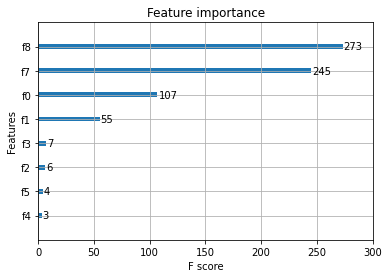

In [ ]:
import matplotlib.pyplot as plt
#xgb.plot_tree(model, num_trees=999)
xgb.plot_importance(model)
#plt.savefig("tree.png", dpi=1000)

In [ ]:
private_test_data = load_private_test_csv("../data")
npprivatetest, npptivatetestlabel = createNpMatrix(private_test_data, s_metadata,user_acc, q_acc, user_num_q, q_num_user, q_age, q_metadata, subject_acc, subject_num, 1, False)
ypred = model.predict(npprivatetest)
pred = []
for i in range(len(private_test_data["user_id"])):
  if ypred[i] >= 0.5:
    pred.append(1)
  else:
    pred.append(0)
private_test_data["is_correct"] = pred
save_private_test_csv(private_test_data)